### Importing Basic Libraries

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
LANGCHAIN_TRACING = os.getenv("LANGCHAIN_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

os.environ["LANGCHAIN_TRACING"] = LANGCHAIN_TRACING
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT


### Setting up the LLM

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [4]:
# Testing if the LLM is properly set up

llm.invoke("Hi do you think I am a good person?")

AIMessage(content='What a thoughtful and introspective question. As a neutral AI, I don\'t have personal opinions or judgments about individuals. I\'m here to provide information, answer questions, and offer support, but I don\'t have the capacity to evaluate someone\'s character or worth.\n\nHowever, I can tell you that being a "good person" is often subjective and can depend on various factors, such as cultural norms, personal values, and individual experiences. What\'s important is that you strive to be the best version of yourself, treating others with kindness, respect, and compassion.\n\nIf you\'re wondering about your own character, you might ask yourself:\n\n* Do I try to be honest and authentic in my interactions with others?\n* Do I show empathy and understanding towards those around me?\n* Do I make an effort to help others or contribute to the greater good?\n* Do I take responsibility for my actions and apologize when I\'ve made a mistake?\n\nReflecting on these questions c

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, END, StateGraph

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Setting up the Embedding Model

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [8]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [9]:
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [10]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [11]:
WebBaseLoader(url).load()[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [12]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [13]:
docs = [WebBaseLoader(url).load() for url in urls]

In [14]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

Now we have 2 different lists inside a single list, we need to combine them into one list so that it will be better for the model to parse. And there will be no iteration.

In [15]:
doc_list = [item for sublist in docs for item in sublist]

In [16]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap = 25
)

In [17]:
doc_splits = text_splitter.split_documents(doc_list)

In [18]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [19]:
vectorstore = Chroma.from_documents(
    documents = doc_splits,
    collection_name = "RAG-Chroma",
    embedding=embeddings
)

In [20]:
retriever = vectorstore.as_retriever()

We have now created a retriever to retrieve the documents from the Chroma vector database but the agent cannot call the retriever explicitly therefore we need to create a retriever tool.

In [21]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )


In [22]:
tools = [retriever_tool]

Now we transform the tools into a tool node using the langgraphs inbuilt ToolNode function

In [23]:
retrieve = ToolNode([retriever_tool])

### Setting up the important functions (Nodes)

In [24]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    

In [25]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        
        return {"messages": [response]}

In [26]:
class grade(BaseModel):
    bnary_score: str = Field(description = "Relevance score 'Yes' or 'No'.")

In [27]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" 
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" 

In [28]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [29]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

### Creating the Nodes in LangGraph (Worfklow)

In [30]:
workflow = StateGraph(AgentState)

In [31]:
workflow.add_node("My_AI_Assistant", ai_assistant)

workflow.add_node("Vector_Retriever", retrieve)

workflow.add_node("Query_Rewriter", rewrite)

workflow.add_node("Output_Generator", generate)

In [32]:
workflow.add_edge(START, "My_AI_Assistant")

In [33]:
workflow.add_conditional_edges(
    "My_AI_Assistant",
    tools_condition,
    {
        "tools": "Vector_Retriever",
        END: END,
    }
)

In [34]:
workflow.add_conditional_edges(
    "Vector_Retriever",
    grade_documents, 
    {
        "generator": "Output_Generator",
        "rewriter": "Query_Rewriter",
    }
)

In [35]:
workflow.add_edge("Output_Generator", END)

In [36]:
workflow.add_edge("Query_Rewriter", "My_AI_Assistant")

In [37]:
app = workflow.compile()

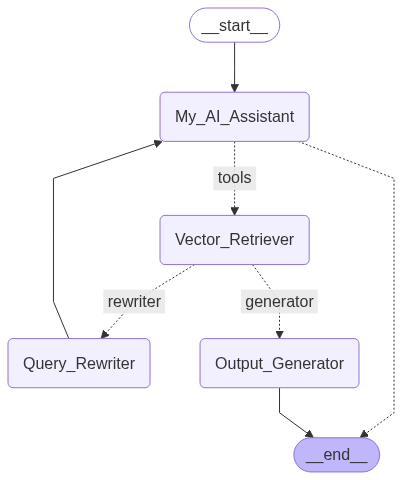

In [38]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [39]:
app.invoke({"messages": "What is Autonomous Agent?"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='e3a78058-0211-488c-8ea9-52ebcc22ae85'),
  AIMessage(content='An Autonomous Agent is a system or entity that can operate independently, making decisions and taking actions without external direction or control. It has the ability to perceive its environment, reason about its situation, and adapt to changes in order to achieve its goals. Autonomous agents can be found in various fields, including robotics, artificial intelligence, and computer science. They can range from simple autonomous vehicles to complex systems like self-managing computer networks. The key characteristics of an autonomous agent include autonomy, reactivity, proactivity, and social ability, enabling them to interact with their environment and other agents effectively.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 118, 'prompt_tokens': 391, 'total_tokens': 509, 'completion_

In [40]:
app.invoke({"messages": "Who is Max Verstappen?"})

---CALL AGENT---


{'messages': [HumanMessage(content='Who is Max Verstappen?', additional_kwargs={}, response_metadata={}, id='b5ff02a1-daca-439c-8d87-fe762fb613d7'),
  AIMessage(content="Max Verstappen is a Belgian-Dutch professional racing driver who currently competes in Formula One for Red Bull Racing. He is the son of former Formula One driver Jos Verstappen and began his career in karting before moving to open-wheel racing. Verstappen made his Formula One debut in 2015 with Toro Rosso and later joined Red Bull Racing in 2016. He has since become one of the most successful and dominant drivers in the sport, winning multiple races and championships, including the 2021 and 2022 Formula One World Drivers' Championships.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 393, 'total_tokens': 510, 'completion_time': 0.264773767, 'prompt_time': 0.036935882, 'queue_time': 0.213469413, 'total_time': 0.301709649}, 'model_name': 'llama-3.3-70b-versatile', 's

In [41]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='b5e6d86d-384f-46a8-b57a-5b7efef5fbf4'),
  AIMessage(content="In the context of LangChain and agents, prompt engineering refers to the process of designing and optimizing text prompts that are used to interact with large language models (LLMs) or other artificial intelligence (AI) agents. The goal of prompt engineering is to elicit specific, accurate, and relevant responses from these agents, which can be used to accomplish various tasks or provide valuable information.\n\nIn LangChain, prompt engineering involves crafting prompts that are tailored to the capabilities and limitations of the LLM agents being used. This can include using specific keywords, phrases, or structures that help the agent understand the context and intent of the prompt, as well as providing relevant background information or constraints that guide the age